Entrenar modelos de regresión para predecir edades en el conjunto de datos UTKFace. La solución debe cumplir con los siguientes puntos.
* Implementar la tubería de datos usando el conjunto de rostros alineados y recortados (https://cloud.xibalba.com.mx/s/sNcxdr2o7aeM7yF)
* Agregar acrecentamiento de datos usando un espejeo horizontal.
* Particionar aleatoriamente en subconjuntos entrenamiento 80 % y prueba 20 %
* Usando transferencia de conocimiento, entrenar un modelo reentrenando solo la última capa.
* Usando transferencia de conocimiento, entrenar un modelo reentrenando toda la red.
* Discutir el comportamiento durante el entrenamiento y resultados finales en ambos conjuntos.

In [1]:
!pip install torch-summary
!pip install wget

<a href="https://colab.research.google.com/drive/1Oi061wN84AdU_qeYwzvOi8o5DXXXqYzf?usp=sharing" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#importamos librerias utiles
#deep learning
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as func
import torch.optim as optimizerr
import torchvision.datasets.utils as tutils
import torchvision.datasets as DataSets
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchsummary import summary
import torchvision.models as torchModels
from torch.utils.tensorboard import SummaryWriter
#matrices y matematicas
import numpy as np
import pandas as pd
# tomar n elementos de una secuencia
from itertools import islice as take
#imagenes
from matplotlib import pyplot as plt
from PIL import Image
#descarga de archivos
import wget
#para acceder a ficheros del sistema
import os
import glob
#para descomprimir el archivo UTKFace.tar.gz
import tarfile
# barra de progreso
from tqdm import trange
#para reproducibilidad
import random
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [3]:
#para usar la GPU si esta disponible
if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"

device = torch.device(dev)
print('Usando {}'.format(device))

Usando cuda:0


### Descargamos los datos

In [4]:
#wget.download('http://cloud.xibalba.com.mx/s/sNcxdr2o7aeM7yF/download','UTKFace.tar.gz')

### Extraemos las imagenes

In [5]:
#tar = tarfile.open('UTKFace.tar.gz', 'r:gz')
#tar.extractall()
#tar.close()
#carpeta = 'UTKFace'

Según https://susanqq.github.io/UTKFace/ cada imagen en el dataset de UTKFace viene nombrado como [age]\_[gender]\_[race]\_[date&time].jpg por lo que las etiquetas se encuentran autocontenidas en el mismo archivo. De esta forma es posible obtenerlas al leer el nombre de cada imagen

In [6]:
carpeta = 'UTKFace'
#funcion para extraer las edades de los archivos jpg
def getAges(carpeta):
    #funcion para extraer la edad de una sola imagen
    def getAgeIndividual(path):
        #guarda solo el nombre y extension de la imagen no la rauta y nombre
        fileName = os.path.split(path)[1]
        #guarda solo el nombre sin extension
        fileName = os.path.splitext(fileName)[0]
        #guarda la edad, que sera el primer elemento del nombre
        age = fileName.split('_')[0]
        # regresa la edad en forma de int
        return int(age)
    
    #define el path de todas las imagenes
    files = glob.glob(os.path.join(carpeta, '*.jpg'))
    #lista vacia para guardar las edades
    records = []
    #itera sobre todos los archivos
    for file in files:
        #usa la funcion de extraer edad para una sola imagen
        info = getAgeIndividual(file)
        #guarda la edad en la lista
        records.append(info)
    #define un dataframe de pandas con las edades    
    df = pd.DataFrame(records)
    #agrega una nueva columna al df de pandas llamada file con la ruta del archivo
    df['file'] = files
    #renombra la columna de edades a age
    df.columns = ['age', 'file']
    #tira a la basura valores NaN si es que existen en el df
    df = df.dropna()
    #regresa el df
    return df

In [7]:
#obtenemos el dataframe de edades y rutas de imagen
df = getAges(carpeta)
df.head(10)

,age,file
0,100,UTKFace\100_0_0_20170112213500903.jpg.chip.jpg
1,100,UTKFace\100_0_0_20170112215240346.jpg.chip.jpg
2,100,UTKFace\100_1_0_20170110183726390.jpg.chip.jpg
3,100,UTKFace\100_1_0_20170112213001988.jpg.chip.jpg
4,100,UTKFace\100_1_0_20170112213303693.jpg.chip.jpg
5,100,UTKFace\100_1_0_20170112215032192.jpg.chip.jpg
6,100,UTKFace\100_1_0_20170117195420803.jpg.chip.jpg
7,100,UTKFace\100_1_0_20170119212053665.jpg.chip.jpg
8,100,UTKFace\100_1_2_20170105174847679.jpg.chip.jpg
9,100,UTKFace\100_1_2_20170112213615815.jpg.chip.jpg


In [8]:
#Hacemos un shuffle de una vez
df = df.sample(frac = 1,random_state=1).reset_index(drop=True)
df

,age,file
0,23,UTKFace\23_1_0_20170116221715630.jpg.chip.jpg
1,16,UTKFace\16_1_0_20170109213044006.jpg.chip.jpg
2,36,UTKFace\36_1_4_20170112234015846.jpg.chip.jpg
3,28,UTKFace\28_0_0_20170116210101534.jpg.chip.jpg
4,48,UTKFace\48_0_0_20170104182220669.jpg.chip.jpg
...,...,...
23703,30,UTKFace\30_1_0_20170117151337477.jpg.chip.jpg
23704,48,UTKFace\48_0_0_20170104211541076.jpg.chip.jpg
23705,25,UTKFace\25_0_3_20170104214444117.jpg.chip.jpg
23706,32,UTKFace\32_1_2_20170116175135519.jpg.chip.jpg


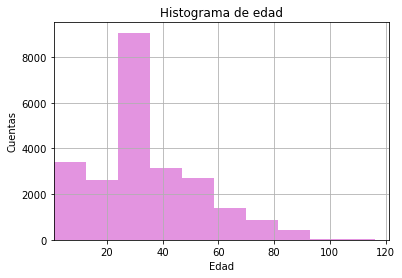

In [9]:
#graficando el histograma de edades
fig = plt.hist(df['age'], facecolor='orchid', alpha=0.75)
plt.xlabel('Edad')
plt.ylabel('Cuentas')
plt.title('Histograma de edad')
plt.xlim(1, 121)
plt.grid(True)
plt.show()

## Dividimos el dataset en entrenamiento y validacion
como el dataframe ya esta shufleado podemos tomar particiones del mismo para validacion y entrenamiento

In [10]:
#definimos el entero que corresponde al 80% de los datos
ochentaPorciento = int(len(df)*0.8)
#definimos el entero que corresponde al 20% de los datos se le suma uno porque me di cuenta que una imagen
#no entraba en ninguno de los dos conjuntos
veintePorciento = int(len(df)*0.2)+1
#print para verificar
print('El conjunto de entrenamiento consiste de {} imagenes, el 80% del mismo es {} mientras que el 20% es {}'.format(
    len(df), ochentaPorciento, veintePorciento))

#definimos el dataFrame de entrenamiento
trainDf = df[:ochentaPorciento]
#definimos el dataFrame de validacion
testDf = df[ochentaPorciento:]
#reseteamos los indices de ambos datasets
testDf =testDf.reset_index(drop=True)
trainDf = trainDf.reset_index(drop=True)

#print para verificar
print('la longitud de train es {}, mientras que test es {}'.format(trainDf.shape, testDf.shape))
#verifiquemos que el ultimo de train no este en el primero de test
print('La ruta de la ultima imagen de train es {}, y la ruta de la primer imagen de test es{}'.format(
    trainDf['file'][18965],testDf['file'][0]))

El conjunto de entrenamiento consiste de 23708 imagenes, el 80% del mismo es 18966 mientras que el 20% es 4742
la longitud de train es (18966, 2), mientras que test es (4742, 2)
La ruta de la ultima imagen de train es UTKFace\38_1_0_20170117121922741.jpg.chip.jpg, y la ruta de la primer imagen de test esUTKFace\7_1_0_20170109204550837.jpg.chip.jpg


In [11]:
testDf.to_csv('test.csv', index=False)
testDf

,age,file
0,7,UTKFace\7_1_0_20170109204550837.jpg.chip.jpg
1,22,UTKFace\22_0_1_20170113150443999.jpg.chip.jpg
2,28,UTKFace\28_1_1_20170117022229804.jpg.chip.jpg
3,42,UTKFace\42_1_0_20170103181418742.jpg.chip.jpg
4,52,UTKFace\52_0_2_20170116183811379.jpg.chip.jpg
...,...,...
4737,30,UTKFace\30_1_0_20170117151337477.jpg.chip.jpg
4738,48,UTKFace\48_0_0_20170104211541076.jpg.chip.jpg
4739,25,UTKFace\25_0_3_20170104214444117.jpg.chip.jpg
4740,32,UTKFace\32_1_2_20170116175135519.jpg.chip.jpg


In [12]:
testDf.to_csv('train.csv', index=False)
trainDf

,age,file
0,23,UTKFace\23_1_0_20170116221715630.jpg.chip.jpg
1,16,UTKFace\16_1_0_20170109213044006.jpg.chip.jpg
2,36,UTKFace\36_1_4_20170112234015846.jpg.chip.jpg
3,28,UTKFace\28_0_0_20170116210101534.jpg.chip.jpg
4,48,UTKFace\48_0_0_20170104182220669.jpg.chip.jpg
...,...,...
18961,55,UTKFace\55_1_0_20170117145739403.jpg.chip.jpg
18962,37,UTKFace\37_0_3_20170120221511381.jpg.chip.jpg
18963,21,UTKFace\21_1_2_20170116220123101.jpg.chip.jpg
18964,31,UTKFace\31_1_0_20170112233727598.jpg.chip.jpg


## Creamos una clase UTKFaces de pytorch Dataset para nuestro conjunto de datos

In [13]:
class UTKFaces(Dataset):
    #init come el dataframe creado en celdas anteriores e incluimos la opcion de aplicar transformaciones
    def __init__(self, dataFrame, transform = None):
        #definimos las variables locales
        self.utkFacesFrame = pd.read_csv(dataFrame)
        self.transform = transform
    #funcion para determinar la longitud de nuestro dataset    
    def __len__(self):
        return len(self.utkFacesFrame)
    #funcion para regresar un elemento del dataset    
    def __getitem__(self, idx):
        #if torch.is_tensor(idx):
        #    idx = idx.tolist()
        #path a la imagen    
        imgName = self.utkFacesFrame['file'][idx]
        #abre la imagen
        image = Image.open(imgName)
        #si hay transformacion aplicala
        if self.transform is not None:
            image = self.transform(image)
        #abre la edad
        age = self.utkFacesFrame['age'][idx]
        #guarda en diccionario tanto la imagen como la edad
        sample = {'image': image, 'age':age}
        #regresa diccionario
        return sample

### Verificacion/Debug

In [14]:
#instancia el dataset
dataset = UTKFaces('train.csv')
#jala una muestra
sample = dataset[0]

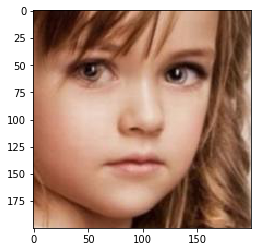

In [15]:
#checa imagen
plt.imshow(sample['image'])

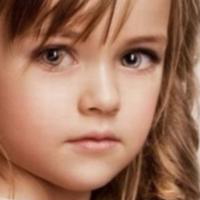

In [16]:
#checa el shape
sample['image']

In [17]:
#checa la edad
sample['age']

7

## Definimos las transformaciones

In [18]:
#Sembramos semilla aleatoria para reproducibilidad
torch.manual_seed(2021)
#creamos las transformaciones para el dataset de entrenamiento
transformForTrain = transforms.Compose([
    #redimensionamos al tamaño de ImageNet 224x224
    transforms.Resize(224),
    #dado que las imagenes son de 200x200 no es necario hacer centercrop
    #aplicamos modificacion aleatoria espejeo horizontal
    transforms.RandomHorizontalFlip(),
    #convertimos a tensor    
    transforms.ToTensor(),
    #normalizamos a la media y varianza de ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Creamos las transformaciones para el dataset de validacion
transformForVal = transforms.Compose([
    #redimensionamos al tamaño de ImageNet 224x224
    transforms.Resize(224),
    #dado que las imagenes son de 200x200 no es necario hacer centercrop
    #convertimos a tensor    
    transforms.ToTensor(),
    #normalizamos a la media y varianza de ImageNet
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Instanciamos ambos datasets con sus respectivas transformaciones
trainDataset = UTKFaces('train.csv', transform = transformForTrain)
testDataset = UTKFaces('test.csv', transform = transformForVal)

## Funcion para ver imagenes

In [19]:
def showBatch(imLisst, titlesList, rows, cols):
    def showImages(imList, titlesList, rows, cols):
        #definimos un grid de imagenes 
        fig, ax = plt.subplots(rows, cols, figsize = (15,15))
        #auxiliar para poner las imagenes en su lugar
        counter = 0
        #itera sobre las filas
        for row in range(rows):
            #itera sobre las columnas
            for col in range(cols):
                #muestra la imagen en su posicion
                ax[row, col].imshow(imList[counter])
                ax[row, col].set_title(titlesList[counter])
                counter += 1
        #muestra el grid
        plt.show()
    #renormaliza, es decir pasa de valores entre 0 y 1 a valores de 0 a 256 (deshace la transformacion)    
    for c, (mean, std) in enumerate(zip([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])):
        imLisst[:, c] = imLisst[:, c]* std + mean
    imLisst *= 255
    #cambia los canales
    imLisst = imLisst.permute(0,2,3,1)
    #pasalo a uint8
    imLisst = (imLisst.numpy()).astype(np.uint8)
    #usa la funcion de grid
    showImages(imLisst, titlesList, rows, cols)
    print('Done! ;)')

## Cargando datos

x shape=torch.Size([16, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([16]) dtype=torch.int64


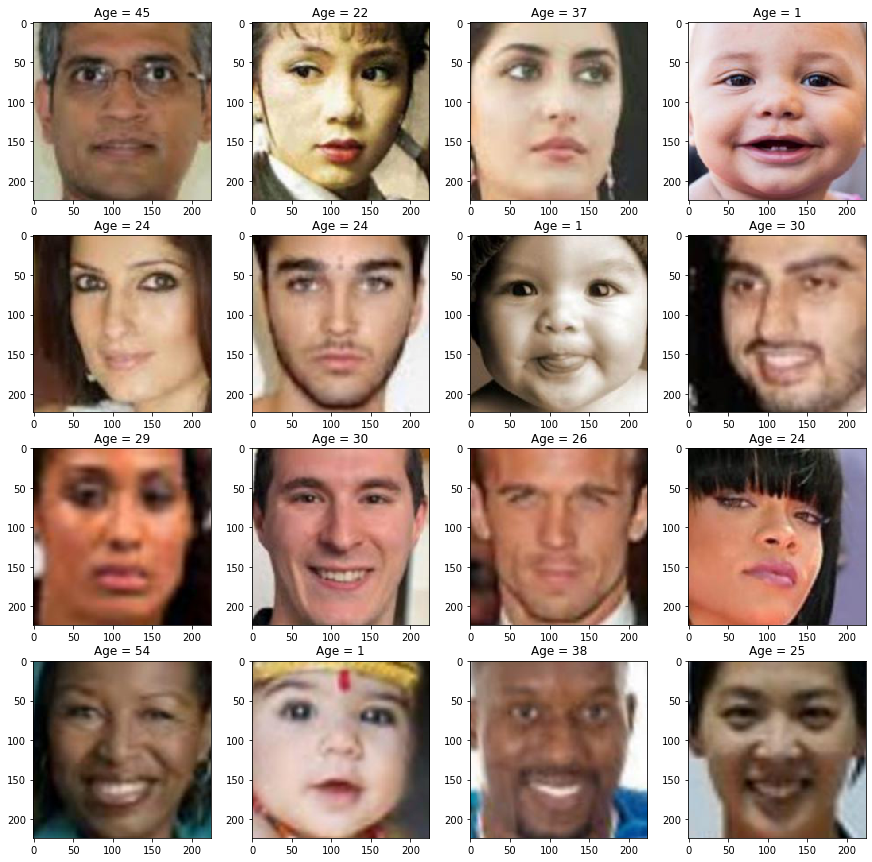

Done! ;)


In [20]:
#creamos el cargador de datos de entrenamiento con un tamaño de lote de 32, se hace shuffle.
#no usar otro numero de num_workers de cero porque si no no jala ¿Error de pytorch?
trainLoader = DataLoader(trainDataset, batch_size=16, shuffle=True, num_workers=0)

#mostramos las primeras 16 imagenes de un lote
lote = next(iter(trainLoader))
x, edades = lote['image'], lote['age']
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={edades.shape} dtype={edades.dtype}')
titles = [f'Age = {l}' for l in edades]
showBatch(x,titles,4,4)

x shape=torch.Size([16, 3, 224, 224]) dtype=torch.float32
y shape=torch.Size([16]) dtype=torch.int64


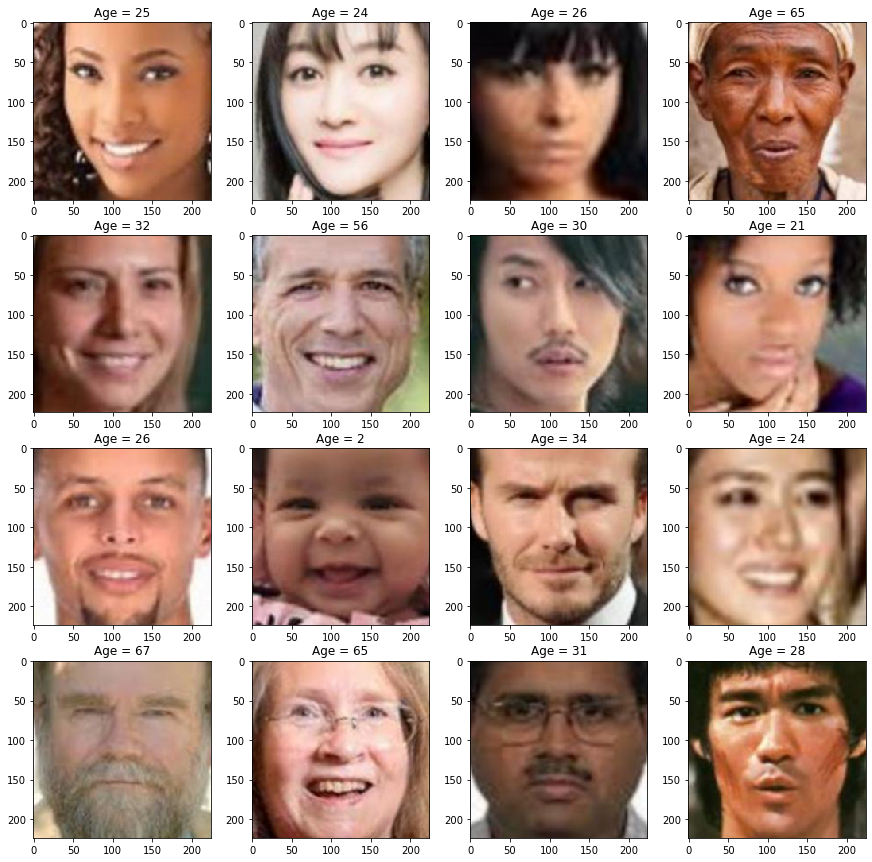

Done! ;)


In [21]:
#creamos el cargador de datos de entrenamiento con un tamaño de lote de 32, se hace shuffle.
#no usar otro numero de num_workers de cero porque si no no jala ¿Error de pytorch?
testLoader = DataLoader(testDataset, batch_size=16, shuffle=True, num_workers=0)

#mostramos las primeras 16 imagenes de un lote
lote = next(iter(trainLoader))
x, edades = lote['image'], lote['age']
print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={edades.shape} dtype={edades.dtype}')
titles = [f'Age = {l}' for l in edades]
showBatch(x,titles,4,4)

## Carga del Modelo preentrenado

In [22]:
model = torchModels.squeezenet1_1(pretrained=True)
summary(model, (3, 224, 224), device=device, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 13, 13]         --
|    └─Conv2d: 2-1                       [-1, 64, 111, 111]        1,792
|    └─ReLU: 2-2                         [-1, 64, 111, 111]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 55, 55]          --
|    └─Fire: 2-4                         [-1, 128, 55, 55]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 55, 55]          1,040
|    |    └─ReLU: 3-2                    [-1, 16, 55, 55]          --
|    |    └─Conv2d: 3-3                  [-1, 64, 55, 55]          1,088
|    |    └─ReLU: 3-4                    [-1, 64, 55, 55]          --
|    |    └─Conv2d: 3-5                  [-1, 64, 55, 55]          9,280
|    |    └─ReLU: 3-6                    [-1, 64, 55, 55]          --
|    └─Fire: 2-5                         [-1, 128, 55, 55]         --
|    |    └─Conv2d: 3-7                  [-1, 16, 55, 55]          2,064


In [23]:
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [24]:
#creamos un nuevo clasificador adaptado a nuestras clases
newClassifier = nn.Sequential(
            nn.Dropout(p = 0.5, inplace = False),
            nn.Conv2d(512,118, kernel_size=(1,1), stride = (1,1)),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(output_size=(1,1)),
        )       

## Congelamos parametros

In [25]:
#Esta celda solo debe ejecutarse una vez ya que para la segunda vez las estadisticas y pesos
#de la capa de clasificacion tambien se congelan
# congelamos los parámetros
for parameter in model.parameters():
    parameter.requires_grad = False
# congelamos las estadísticas
model.eval()

# remplazo de última capa
model.classifier = newClassifier

# inspección, note la cantidad de parametros entrenables
summary(model, (3, 224, 224), 
        device=device, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 13, 13]         --
|    └─Conv2d: 2-1                       [-1, 64, 111, 111]        (1,792)
|    └─ReLU: 2-2                         [-1, 64, 111, 111]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 55, 55]          --
|    └─Fire: 2-4                         [-1, 128, 55, 55]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 55, 55]          (1,040)
|    |    └─ReLU: 3-2                    [-1, 16, 55, 55]          --
|    |    └─Conv2d: 3-3                  [-1, 64, 55, 55]          (1,088)
|    |    └─ReLU: 3-4                    [-1, 64, 55, 55]          --
|    |    └─Conv2d: 3-5                  [-1, 64, 55, 55]          (9,280)
|    |    └─ReLU: 3-6                    [-1, 64, 55, 55]          --
|    └─Fire: 2-5                         [-1, 128, 55, 55]         --
|    |    └─Conv2d: 3-7                  [-1, 16, 55, 55]        

## Definimos la funcion de entrenamiento

In [26]:
#funcion para entrenar una epoca
def trainModelOneEpoch(dataLoader, model, optimizer):
    #model = model.to(device, non_blocking=True)
    #entrenamiento de una epoca
    for batch in dataLoader:
        x = batch['image']
        x = x.to(device, non_blocking=True)
        realAge = batch['age']
        realAge = realAge.to(device, non_blocking=True)
        #calculamos los logits
        logits = model(x)
        #calculamos la perdida
        loss = func.cross_entropy(logits, realAge)
        #vaciamos los gradientes
        optimizer.zero_grad()
        #retropropagacion
        loss.backward()
        #actualizacion de parametros
        optimizer.step()

#funcion para evaluar epocas
def evalEpoch(dataLoader, model, numBatches = None):
    #model = model.to(device, non_blocking=True)
    #no se actualizan pesos
    with torch.no_grad():
        losses, accs = [], []
        #validacion en una epoca con numBatches
        for batch in take(dataLoader, numBatches):
            x = batch['image']
            x = x.to(device, non_blocking=True)
            realAge = batch['age']
            realAge = realAge.to(device, non_blocking=True)
            #calculamos los logits
            logits = model(x)
            #calculamos la probabilidad de clases
            proba = func.softmax(logits,1)
            #obtenemos la clase con mayor probabilidad
            prediction = torch.argmax(proba,1)
            #calculamos la perdida
            loss = func.cross_entropy(logits, realAge)
            #calculamos la exactitud
            acc = (realAge == prediction).type(torch.float32).mean()
            #guarda los historicos
            losses.append(loss.item())
            accs.append(acc.item())
        loss = np.mean(losses)*100
        accs = np.mean(accs)*100
        #print('Perdida:{0}   Accuracy:{1}'.format(loss, acc))
        return loss, accs
    
#funcion para guardar check points
def checkPoint(model, epoch, directory):
    torch.save({'epoch': epoch, 'modelStateDict': model.state_dict(),}, os.path.join(directory, 'weights.pth'))
    
#funcion para entrenar n epocas
def train(model, trainData, testData, trainWriter, testWriter, epochs, trainBatches = None, testBatches = None):
    torch.manual_seed(2021)
    model = model.to(device, non_blocking=True)
    lossHistory = []
    accuracyHistory = []
    #instanciamos el optimizador
    optimizer = optimizerr.Adam(model.parameters(), lr=1e-3)
    #congelamos los pesos y las estadisticas ya que estamos haciendo transferencia
    model.eval()
    #Entrenando por epochas
    bestAcc = 0
    for epoch in trange(epochs):
        #entrenamos una epoca
        trainModelOneEpoch(trainData, model, optimizer)
        #evaluamos la epoca recien entrenada
        trainLoss , trainAcc = evalEpoch(trainData, model, trainBatches)
        lossHistory.append(trainLoss)
        accuracyHistory.append(trainAcc)
        #trazas de tensorboard
        trainWriter.add_scalar('metrics/loss', trainLoss, epoch)
        trainWriter.add_scalar('metrics/acc', trainAcc, epoch)        
        #guara un punto de control si y solo si hay una mejora
        if trainAcc > bestAcc:
            bestAcc = trainAcc
            checkPoint(model, epoch, directory)
    return lossHistory, accuracyHistory

In [27]:
#creamos el directorio donde se guardaran los pesos del modelo congelado
directory = os.path.join('runs', 'facesTransfer')
print(directory)
#instanciamos los escritores de trazas de tensorboard
trainWriter = SummaryWriter(os.path.join(directory, 'train'))
testWriter = SummaryWriter(os.path.join(directory, 'test'))

runs\facesTransfer


In [29]:
# entrenamos modelo
l,a = train(model, trainLoader, testLoader, trainWriter, testWriter, 
      epochs=50, trainBatches=5, testBatches=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [06:53<00:00,  8.26s/it]


In [38]:
# cargamos el punto de control
ckpt = torch.load(os.path.join(directory, 'weights.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

Best epoch 39


In [61]:
# instanciamos un modelo vacio
model = torchModels.squeezenet1_1()
model = model.to(device, non_blocking=True)
# remplazo de última capa
model.classifier = newClassifier
# cargamos pesos
state_dict = ckpt['modelStateDict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()

In [62]:
#calculamos la perdida y accuracy de los datasets de entrenamiento y test
trn_loss, trn_acc = evalEpoch(trainLoader, model)
val_loss, val_acc = evalEpoch(testLoader, model)

In [65]:
#imprimimos los valores recien calculados
print(f'trn_acc={trn_acc:5.2f} val_acc={val_acc:5.2f}')
print(f'trn_loss={trn_loss:6.2f} val_loss={val_loss:6.2f}')

trn_acc=64.98 val_acc=65.92
trn_loss=147.26 val_loss=146.60


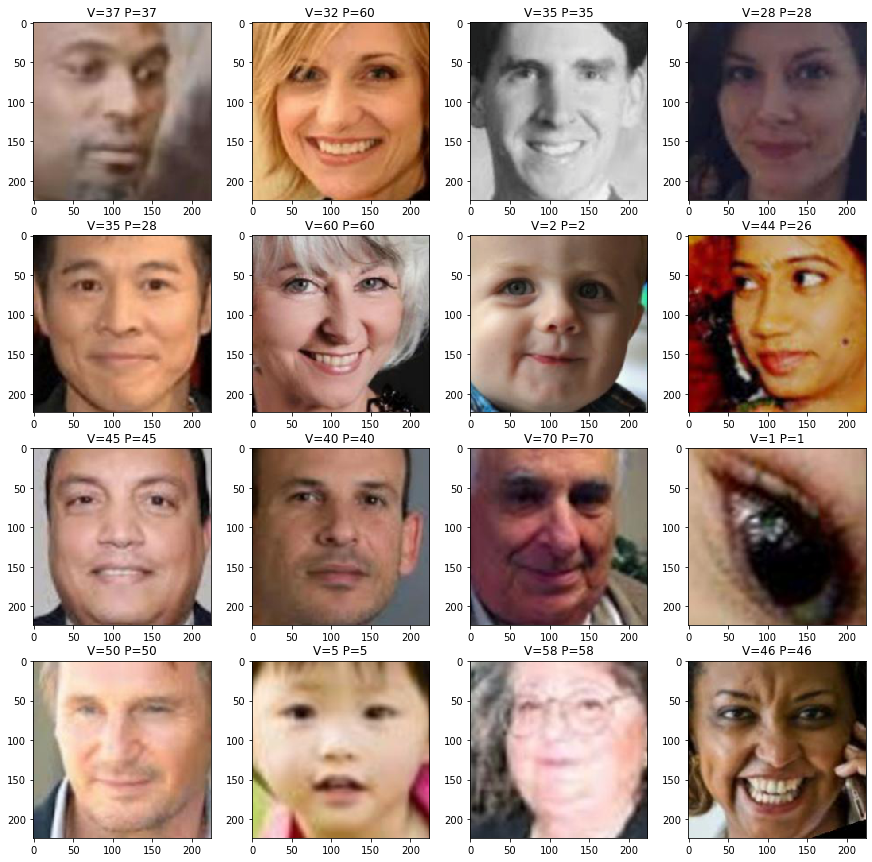

Done! ;)


In [66]:
#hacemos inferencia sobre uno de los lotes de test y desplegamos las imagenes con su edad real (V) y su prediccion (P)
with torch.no_grad():
    batch = next(iter(testLoader))
    x, y_true = batch['image'], batch['age']
    x = x.to(device, non_blocking=True)
    y_true = y_true.to(device, non_blocking=True)
    y_pred = torch.argmax(func.softmax(model(x), 1), 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    showBatch(x.cpu(), titles, 4, 4)

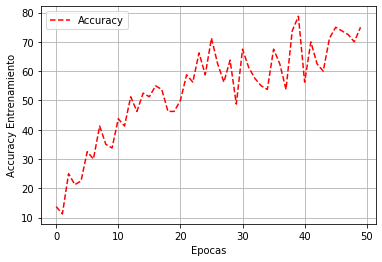

In [52]:
## Creamos una funcion que grafica los datos de accuracy en entrenamiento:
def graficaAcc(accurac):
    plt.plot(np.arange(len(accurac)), accurac, '--', label='Accuracy', color = 'red')
    plt.legend()
    plt.xlabel('Epocas')
    plt.ylabel('Accuracy Entrenamiento')
    plt.grid(True)
    plt.show()
#grafica el accuracy del entrenamiento del modelo congelado
graficaAcc(a)

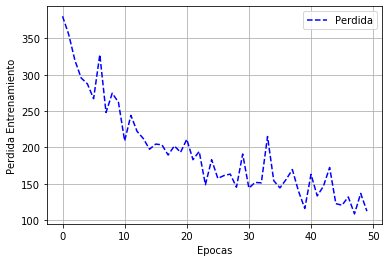

In [54]:
## Creamos una funcion que grafica los datos de la perdida en entrenamiento:
def graficaLoss(perdidas):
    plt.plot(np.arange(len(perdidas)), perdidas, '--', label='Perdida', color = 'blue')
    plt.legend()
    plt.xlabel('Epocas')
    plt.ylabel('Perdida Entrenamiento')
    plt.grid(True)
    plt.show()
#grafica la perdida del entrenamiento del modelo congelado    
graficaLoss(l)

## Entrenamos un nuevo modelo sin congelar estadisticas

In [69]:
#instanciamos una nueva red sin pesos entrenados y sin congelar
newModel = torchModels.squeezenet1_1()
newModel.classifier = newClassifier
newModel

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [70]:
#hacemos summary del modelo sin congelar, note la cantidad de parametros entrenables
summary(newModel, (3, 224, 224), device = device, verbose=0)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 512, 13, 13]         --
|    └─Conv2d: 2-1                       [-1, 64, 111, 111]        1,792
|    └─ReLU: 2-2                         [-1, 64, 111, 111]        --
|    └─MaxPool2d: 2-3                    [-1, 64, 55, 55]          --
|    └─Fire: 2-4                         [-1, 128, 55, 55]         --
|    |    └─Conv2d: 3-1                  [-1, 16, 55, 55]          1,040
|    |    └─ReLU: 3-2                    [-1, 16, 55, 55]          --
|    |    └─Conv2d: 3-3                  [-1, 64, 55, 55]          1,088
|    |    └─ReLU: 3-4                    [-1, 64, 55, 55]          --
|    |    └─Conv2d: 3-5                  [-1, 64, 55, 55]          9,280
|    |    └─ReLU: 3-6                    [-1, 64, 55, 55]          --
|    └─Fire: 2-5                         [-1, 128, 55, 55]         --
|    |    └─Conv2d: 3-7                  [-1, 16, 55, 55]          2,064


# Debemos modificar la funcion que entrena ya que la otra esta "optimizada" para el modelo con capas congeladas

In [71]:
#funcion para evaluar epocas
def evaluaEpoch(dataLoader, model, numBatches = None):
    #model = model.to(device, non_blocking=True)
    #no se actualizan pesos
    with torch.no_grad():
        model.eval()
        losses, accs = [], []
        #validacion en una epoca con numBatches
        for batch in take(dataLoader, numBatches):
            x = batch['image']
            x = x.to(device, non_blocking=True)
            realAge = batch['age']
            realAge = realAge.to(device, non_blocking=True)
            #calculamos los logits
            logits = model(x)
            #calculamos la probabilidad de clases
            proba = func.softmax(logits,1)
            #obtenemos la clase con mayor probabilidad
            prediction = torch.argmax(proba,1)
            #calculamos la perdida
            loss = func.cross_entropy(logits, realAge)
            #calculamos la exactitud
            acc = (realAge == prediction).type(torch.float32).mean()
            #guarda los historicos
            losses.append(loss.item())
            accs.append(acc.item())
        loss = np.mean(losses)*100
        accs = np.mean(accs)*100
        #modo entrenamiento
        model.train()
        #print('Perdida:{0}   Accuracy:{1}'.format(loss, acc))
        return loss, accs
    
#funcion para entrenar n epocas
def entrena(model, trainData, trainWriter, epochs, trainBatches = None):
    torch.manual_seed(2021)
    model = model.to(device, non_blocking=True)
    lossHistory = []
    accuracyHistory = []
    #instanciamos el optimizador
    optimizer = optimizerr.Adam(model.parameters(), lr=1e-3)
    #Entrenando por epochas
    bestAcc = 0
    for epoch in trange(epochs):
        #entrenamos una epoca
        trainModelOneEpoch(trainData, model, optimizer)
        #evaluamos la epoca recien entrenada
        trainLoss , trainAcc = evaluaEpoch(trainData, model, trainBatches)
        lossHistory.append(trainLoss)
        accuracyHistory.append(trainAcc)
        #trazas de tensorboard
        trainWriter.add_scalar('metrics/loss', trainLoss, epoch)
        trainWriter.add_scalar('metrics/acc', trainAcc, epoch)        
        #guara un punto de control si y solo si hay una mejora
        if trainAcc > bestAcc:
            bestAcc = trainAcc
            checkPoint(model, epoch, directory)
    return lossHistory, accuracyHistory

In [72]:
#nuevo directorio donde se guardaran los pesos de la red no congelada
directory = os.path.join('runs', 'facesAll')
print(directory)
#instanciamos los escritores de trazas de tensorboard
trainWriterAll = SummaryWriter(os.path.join(directory, 'train'))

runs\facesAll


In [73]:
#entrenamos
lAll, aAll = entrena(newModel, trainLoader, trainWriterAll,epochs=50, trainBatches=5)

100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [09:30<00:00, 11.41s/it]


In [80]:
# cargamos el punto de control
ckpt = torch.load(os.path.join(directory, 'weights.pth'))
# imprimimos la mejor época
best_epoch = ckpt['epoch']
print(f'Best epoch {best_epoch}')

Best epoch 46


In [75]:
# instanciamos un modelo vacio
newModel = torchModels.squeezenet1_1()
newModel = model.to(device, non_blocking=True)
# remplazo de última capa
newModel.classifier = newClassifier
# cargamos pesos
state_dict = ckpt['modelStateDict']
model.load_state_dict(state_dict)

# congelamos las estadísticas
_ = model.eval()

In [81]:
#calculamos la perdida y accuracy de los datasets de entrenamiento y test
trn_loss, trn_acc = evaluaEpoch(trainLoader, newModel)
val_loss, val_acc = evaluaEpoch(testLoader, newModel)

In [83]:
#imprimimos los valores recien calculados
print(f'trn_acc={trn_acc:5.2f} val_acc={val_acc:5.2f}')
print(f'trn_loss={trn_loss:6.2f} val_loss={val_loss:6.2f}')

trn_acc=24.55 val_acc=24.66
trn_loss=316.03 val_loss=315.85


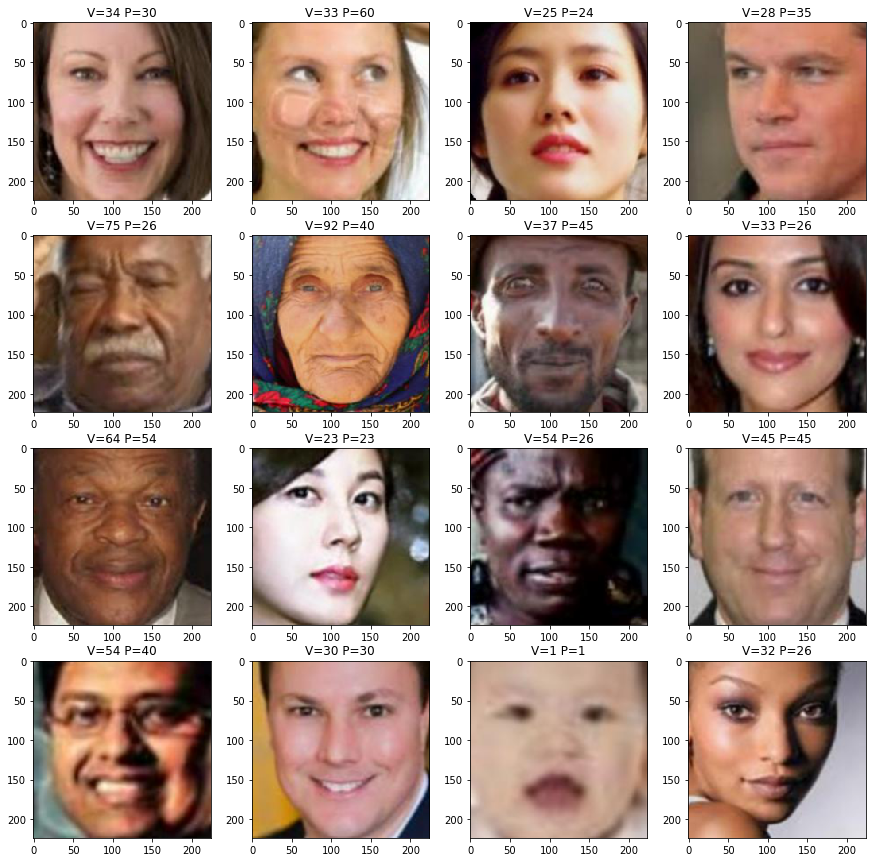

Done! ;)


In [78]:
#hacemos inferencia sobre uno de los lotes de test y desplegamos las imagenes con su edad real (V) y su prediccion (P)
with torch.no_grad():
    batch = next(iter(testLoader))
    x, y_true = batch['image'], batch['age']
    x = x.to(device, non_blocking=True)
    y_true = y_true.to(device, non_blocking=True)
    y_pred = torch.argmax(func.softmax(model(x), 1), 1)
    titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
    showBatch(x.cpu(), titles, 4, 4)

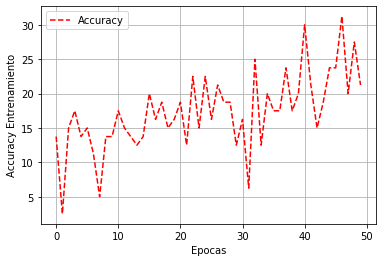

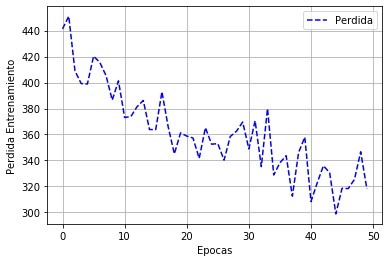

In [79]:
#graficamos la perdida y el accuracy del modelo no congelado
graficaAcc(aAll)
graficaLoss(lAll)

## Discusión/Conclusiones

Es claro que no congelar los pesos y estádisticas del modelo incrementa "sustancialmente" el tiempo de entrenamiento. De los prints y las gráficas de Accuracy muestran que el Accuracy incrementa casi exponencialmente a lo largo de las epocas para el caso de pesos congelados. Alcanzando un máximo de 79% para train y 66% para test. Para el caso del entrenamiento de todas las epocas encontramos un máximo de 30% para train y 25% de test con respecto a los valores de accuracy.
Por otro lado la perdida es mucho mayor (320 pts) cuando se entrena toda la red con respecto a cuando se usa la red con pesos preentrenados (130 pts).
El hecho de que se alcance un mayor Accuracy cuando se emplea la red con pesos congelados es algo casi obvio, ya que recordemos el congelamiento de pesos son en realidad pesos de la red preentrenada en un conjunto de datos (imageNet en este caso) para una cantidad determinada de epocas, mientras que entrenar la red completamente, implica que esta debió ser instanciada con un conjunto de pesos cuyos valores son aleatorios o cero.
A pesar de que los valores de Accuracy son bajos, se cree que al aplicar otras 50 epocas más en el caso de la red de pesos congelados, éste mejorará sustancialmente. Por otro lado el accuracy de la red no congelada requiere muchas mas epocas para obtener accuracys aceptables.

Consideremos, tambien, que si bien es cierto el accuracy es mejor para el modelo congelado, esta tendencia, se cree, no se mantiene. Como hipotesis tenemos lo siguiente: El accuracy del modelo congelado tenderá a un valor especifico para una cantidad determinada de epocas, lo mismo sucede con el modelo no congelado, pero como en el entrenamiento los pesos se encuentran congelados no podrán ser modificados, mientras que para la red no congelada todos los parametros se actualizan a lo largo de las epocas. Entonces el modelo no congelado, a pesar de requerir mas epocas, el accuracy será mejor a lo largo de las mismas ya que los pesos se adaptaran mejor a la tarea especifica.

Finalmente, el accuracy global se ve afectado por el gran desbalance de las clases, por lo que no se espera que el modelo alcance un accuracy significativamente alto.